# Mercedes-Benz - Test Bed Time Reduction

**Competition Description**
Since the first automobile, the Benz Patent Motor Car in 1886, Mercedes-Benz has stood for important automotive innovations. These include, for example, the passenger safety cell with crumple zone, the airbag and intelligent assistance systems. Mercedes-Benz applies for nearly 2000 patents per year, making the brand the European leader among premium car makers. Daimler’s Mercedes-Benz cars are leaders in the premium car industry. With a huge selection of features and options, customers can choose the customized Mercedes-Benz of their dreams.

To ensure the safety and reliability of each and every unique car configuration before they hit the road, Daimler’s engineers have developed a robust testing system. But, optimizing the speed of their testing system for so many possible feature combinations is complex and time-consuming without a powerful algorithmic approach. As one of the world’s biggest manufacturers of premium cars, safety and efficiency are paramount on Daimler’s production lines.

In this competition, Daimler is challenging Kagglers to tackle the curse of dimensionality and reduce the time that cars spend on the test bench. Competitors will work with a dataset representing different permutations of Mercedes-Benz car features to predict the time it takes to pass testing. Winning algorithms will contribute to speedier testing, resulting in lower carbon dioxide emissions without reducing Daimler’s standards.

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

from scipy.special import boxcox, inv_boxcox
from scipy import stats

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score

import xgboost as xgb
import lightgbm
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


import warnings
warnings.filterwarnings('ignore')


In [ ]:
train = pd.read_csv("/kaggle/input/mercedes-benz-greener-manufacturing/train.csv.zip")
submission = pd.read_csv("/kaggle/input/mercedes-benz-greener-manufacturing/sample_submission.csv.zip")
test = pd.read_csv("/kaggle/input/mercedes-benz-greener-manufacturing/test.csv.zip")

## Data
**About dataset**
This dataset contains an anonymized set of variables, each representing a custom feature in a Mercedes car. For example, a variable could be 4WD, added air suspension, or a head-up display.

The ground truth is labeled ‘y’ and represents the time (in seconds) that the car took to pass testing for each variable.

File descriptions
Variables with letters are categorical. Variables with 0/1 are binary values.

train.csv - the training set
test.csv - the test set, you must predict the 'y' variable for the 'ID's in this file
sample_submission.csv - a sample submission file in the correct format

## Objective of the notebook
**From Notebook Author** <br>
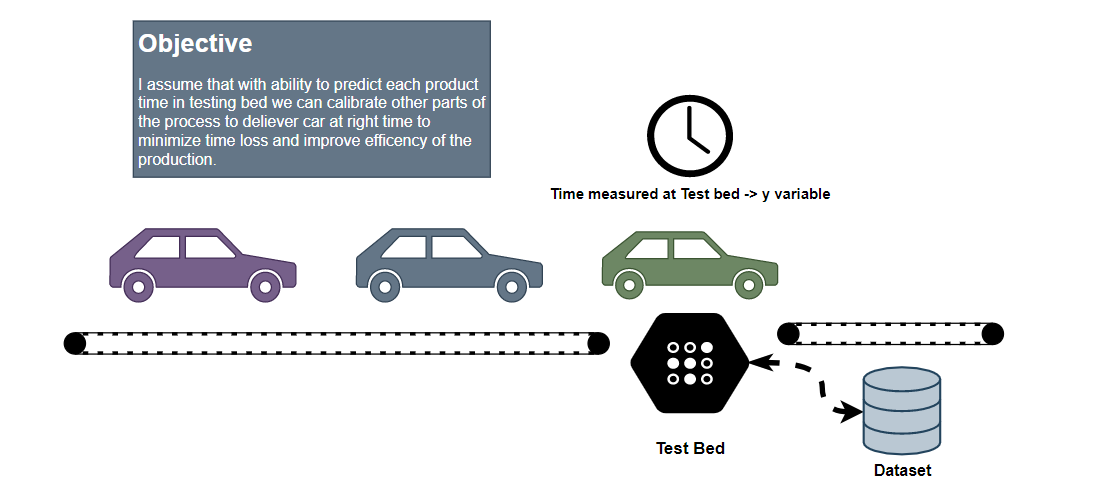

As we can see dimension of dataset is quite large. Majority of the features are binary features, there are some features that have the same min value as max value which means that there is no change in any of data samples. I would assume these features should be dropped to reduce dimensionality of dataset. <br>
Another thing to consider are categorical features. We can encode those but since basically all of the features are sort of binary then I feel it would be beneficial to pick model that does not require things like scaling or normalization. In this case Tree based/ensemble models would be our first choice, so in this case I will go with DecisionTree or Random Forest as our baseline model and LightGBM and XGBoost as potential upgrade.
In terms of encoding I will go with OrdinalEncoder (I don't need to care about scale and I don't want to increase dimension with One-Hot Encoder)

As for stacking, I will not stack models. The reason for this is, well this is potentially production environment and stacking is not the best practice in deployment conditions (If I am wrong, then correct me on this).
Besides its been couple of years since this competition has ended so there is nothing to win. 


In [ ]:
frame = pd.DataFrame({"Max Values":list(train.max()),"Min Values": list(train.min())},index=train.columns)
frame = frame.loc[frame["Max Values"]==frame["Min Values"]]

In [ ]:
train.drop(list(frame.index),axis=1,inplace=True)

In [ ]:
train

## Encoding

In [ ]:
enc = OrdinalEncoder()

In [ ]:
encoded = pd.DataFrame(enc.fit_transform(train[train.dtypes.loc[train.dtypes=="object"].index]),
                       columns=list(train.dtypes.loc[train.dtypes=="object"].index))

for column in encoded.columns:
    train[column] = encoded[column]

In [ ]:
train

## Target Distribution

Here we are going to analyze our target variable distribution and as we can see in fig1, you target variable is maybe not most normally distributed however box cox transformation does not change much. In that case we can stick to original target. 
However for sake of experiment we will try to do it with post boxcox transformation and then with use of Lambda parameter from transformation inverse it and see our predictions.

Generally speaking, models that we are using are Non Parametric models (Decision trees) so we don't have to make assumptions about target distibution, however it doesn't mean that we can't see if that makes a difference.

In [ ]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(211)
prob = stats.probplot(train["y"], dist=stats.norm,plot=ax1)
ax2 = fig.add_subplot(212)
xt, lambda_param = stats.boxcox(train["y"])
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Post Box-Cox transformation')
plt.subplots_adjust(bottom=-1) 

In [ ]:
fig1 = plt.figure(figsize=(12,6))
sns.histplot(train["y"])
plt.title("Original Target Distribution")

In [ ]:
fig1 = plt.figure(figsize=(12,6))
sns.histplot(xt)
plt.title("Post Box-Cox Transformation Target Distribution")

In [ ]:
""" Parameters for training models with before Box-Cox and After Box Cox transformation """ 

y_ = train["y"]
y_boxcox,lambda_param = stats.boxcox(y_)

print(y_.shape)
print(y_boxcox.shape)
print(lambda_param)

## Modeling
We will try 4 models.
1. Decision Trees Regressor
2. Random Forest Regressor
3. LightGBM Regressor
4. XGB Regressor

We will cross validate these models to see predictive ability of each of those models (and dataset)


In [ ]:
X = train[train.columns[2:]]

In [ ]:
dt_model = DecisionTreeRegressor()

rf_model = RandomForestRegressor(max_depth=6, criterion="mae")

lgbm_model = lightgbm.LGBMRegressor(boosting_type='gbdt',
                                    learning_rate=0.06, 
                                    max_depth=5, 
                                    n_estimators = 100,random_state=1)

xgb_model = xgb.XGBRegressor(
                             learning_rate=0.06,
                             max_depth=5,
                             n_estimators=400,random_state=1)

In [ ]:
CV_RESULTS = pd.DataFrame()

In [ ]:
cv_dt = cross_val_score(dt_model,X,y_,cv=10,scoring=('r2'))
cv_dt_boxcox = cross_val_score(dt_model,X,y_boxcox,cv=10,scoring=('r2'))
CV_RESULTS["DecisionTrees"] = cv_dt
CV_RESULTS["DecisionTrees After Box-Cox"] = cv_dt_boxcox

In [ ]:
cv_rf = cross_val_score(rf_model,X,y_,cv=10,scoring=('r2'))
cv_rf_boxcox = cross_val_score(rf_model,X,y_boxcox,cv=10,scoring=('r2'))
CV_RESULTS["RandomForest"] = cv_rf
CV_RESULTS["RandomForest After Box-Cox"] = cv_rf_boxcox

In [ ]:
cv_lgbm = cross_val_score(lgbm_model,X,y_,cv=10,scoring=('r2'))
cv_lgbm_boxcox = cross_val_score(lgbm_model,X,y_boxcox,cv=10,scoring=('r2')) 
CV_RESULTS["LightGBM"] = cv_lgbm
CV_RESULTS["LightGBM After Box-Cox"] = cv_lgbm_boxcox

In [ ]:
cv_xgb = cross_val_score(xgb_model,X,y_,cv=10,scoring=('r2'))
cv_xgb_boxcox = cross_val_score(xgb_model,X,y_boxcox,cv=10,scoring=('r2'))
CV_RESULTS["XGBoost"] = cv_xgb
CV_RESULTS["XGBoost After Box-Cox"] = cv_xgb_boxcox

In [ ]:
CV_RESULTS

It seems like Box Cox transformation really made a difference here. Our best models are RandomForest, XGBoost and then LightGBM, which is quite suprising. I will separate them into train and test set to see their performance in random sampled datasets. For submission I will prepare 4 submission files. One for each model + one for stacked predictions.
Since we have lambda parameter from Box Cox transformation, I can use models trained on box cox dataset to get my predictions.

In [ ]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X,y_,test_size=0.1,random_state=101)
X_train_bc, X_test_bc, y_train_bc, y_test_bc = train_test_split(X,y_boxcox,test_size=0.1,random_state=101)

### Random Forest

In [ ]:
"""RandomForest - Standard Target"""
rf_model.fit(X_train_,y_train_)
rf_predict = rf_model.predict(X_test_)
print("R2 Score: {0}".format(r2_score(y_test_,rf_predict)))

In [ ]:
"""RandomForest - Box Cox Target"""
rf_model.fit(X_train_bc,y_train_bc)
rf_predict_bc = rf_model.predict(X_test_bc)
print("R2 Score: {0}".format(r2_score(y_test_bc,rf_predict_bc)))

### LightGBM

In [ ]:
"""LightGBM - Standard Target"""
lgbm_model.fit(X_train_,y_train_)
lgbm_predict = lgbm_model.predict(X_test_)
print("R2 Score: {0}".format(r2_score(y_test_,lgbm_predict)))

In [ ]:
"""LightGBM - Box Cox Target"""
lgbm_model.fit(X_train_bc,y_train_bc)
lgbm_predict_bc = lgbm_model.predict(X_test_bc)
print("R2 Score: {0}".format(r2_score(y_test_bc,lgbm_predict_bc)))

### XGBoost

In [ ]:
"""XGBoost - Standard Target"""
xgb_model.fit(X_train_,y_train_)
xgb_predict = xgb_model.predict(X_test_)
print("R2 Score: {0}".format(r2_score(y_test_,xgb_predict)))

In [ ]:
"""XGBoost - Box Cox Target"""
xgb_model.fit(X_train_bc,y_train_bc)
xgb_predict_bc = xgb_model.predict(X_test_bc)
print("R2 Score: {0}".format(r2_score(y_test_bc,xgb_predict_bc)))

### Stacked Models

In [ ]:
stacked_ = (xgb_predict + lgbm_predict + rf_predict)/3
print("Stacked R2 Score: {0}".format(r2_score(y_test_,stacked_)))

In [ ]:
stacked_bc = (xgb_predict_bc + lgbm_predict_bc + rf_predict_bc)/3
print("Stacked R2 Score: {0}".format(r2_score(y_test_bc,stacked_bc)))

As we can see, stacked models had overall better performance than any of models alone. In this case I will use 100% of avaiable dataset to train our models and make the predictions using dataset with boxcox transformation. Later I will use lambda parameter to perform inverse box cox transformation to obtain real predictions.

## Submission

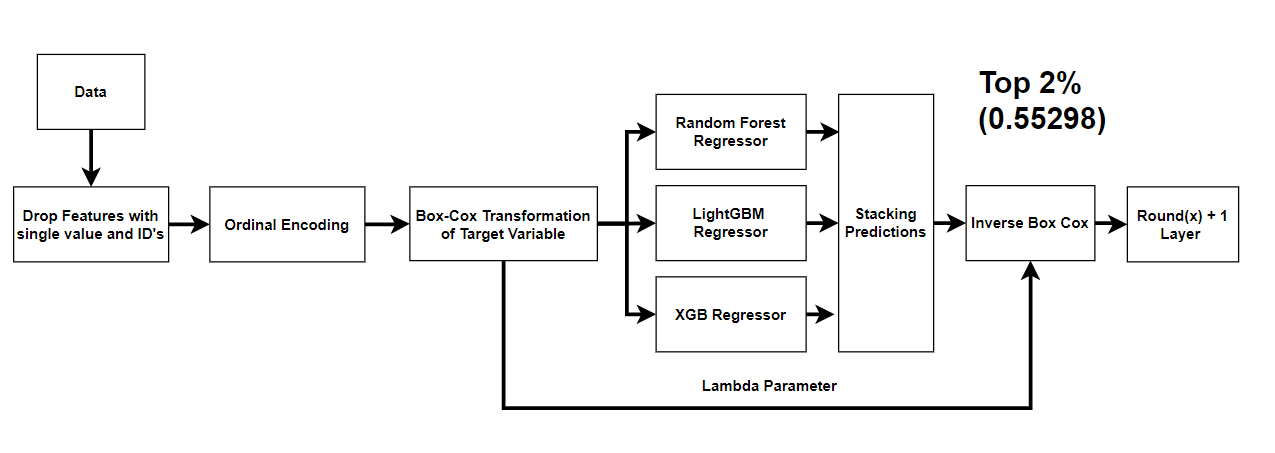

Probably you are going to ask me about last layer which is round(x)+1.
Well generally we want to predict amount of seconds so I have figured that it would be nice to round values and I have noticed small performance boost with that. Secondly I have noticed that my model underpredict a little bit, therefore I added 1 spare second to our prediction.
Also from industrial perspective (real life) it would be good to add some time margin to our predictions, much like when we forecast supply chain and we use confidence interval to deliever slightly more supply than demanded.

Generally I know it is pretty old competition but I had blast doing it and I feel car manufacturing companies are still years ahead of many other manufacturing plants that would also benefits from improvements like this one.

In [ ]:
test_input = test[X.columns]
test_id = test["ID"]

In [ ]:
test_encoded = pd.DataFrame(enc.fit_transform(test_input[test_input.dtypes.loc[test_input.dtypes=="object"].index]),
                       columns=list(test_input.dtypes.loc[test_input.dtypes=="object"].index))

In [ ]:
for column in test_encoded.columns:
    test_input[column] = test_encoded[column]

In [ ]:
rf_model.fit(X,y_boxcox)
lgbm_model.fit(X,y_boxcox)
xgb_model.fit(X,y_boxcox)

In [ ]:
prediction_1 = rf_model.predict(test_input)
prediction_2 = lgbm_model.predict(test_input)
prediction_3 = xgb_model.predict(test_input)

In [ ]:
prediction_final = (prediction_1+prediction_2+prediction_3)/3

In [ ]:
prediction_inverse = inv_boxcox(prediction_final,lambda_param)

In [ ]:
submission["y"]=prediction_inverse

In [ ]:
submission["y"]=submission["y"].apply(lambda x: np.round(x)+1)

In [ ]:
submission

In [ ]:
#submission.to_csv("submission_x_1.csv",index=False)